In [28]:
%run ../common_functions.py

read_dataset()
read_all_datasets()
read_processed_data()
combine_text_columns()
split_train_test()
extract_data()
evaluate_model()
detect_missing_values()


In [29]:
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
import torch
import os
import numpy as np

## Load in Dataset

In [30]:
train_data, test_data = read_processed_data(cross_domain=False, augmented=False, balanced=False)

### Extract data and label mapping

In [33]:
X_train, y_train, X_test, y_test = extract_data(train_df=train_data, test_df=test_data, text_col="text", label_col="label")

### Transform to Vectors

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.backends.mps.is_available() 
                      else "cpu")
print(f"Using device >> {device}")

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)

if os.path.isdir("embeddings"):
    X_train_emb = np.load("embeddings/X_train_emb.npy")
    X_test_emb = np.load("embeddings/X_test_emb.npy")
else:
    X_train_emb = embedder.encode(
        X_train, batch_size=48, show_progress_bar=True
    )
    X_test_emb  = embedder.encode(X_test, batch_size=48)

    os.mkdir("embeddings")
    np.save("embeddings/X_train_emb.npy", X_train_emb)
    np.save("embeddings/X_test_emb.npy", X_test_emb)

Using device >> mps


Batches:   0%|          | 0/5986 [00:00<?, ?it/s]

### Train Logistic Regression Classifier

In [35]:
model = LogisticRegression(
    C=100,
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    penalty='l2',
    solver="liblinear"
)
model.fit(X_train_emb, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,100
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


### Evaluate Model

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74     18120
           1       0.65      0.70      0.67     13803

    accuracy                           0.71     31923
   macro avg       0.70      0.71      0.70     31923
weighted avg       0.71      0.71      0.71     31923


Overall Metrics:
Accuracy       : 0.7073
Precision (avg): 0.7104
Recall    (avg): 0.7073
F1 Score  (avg): 0.7082



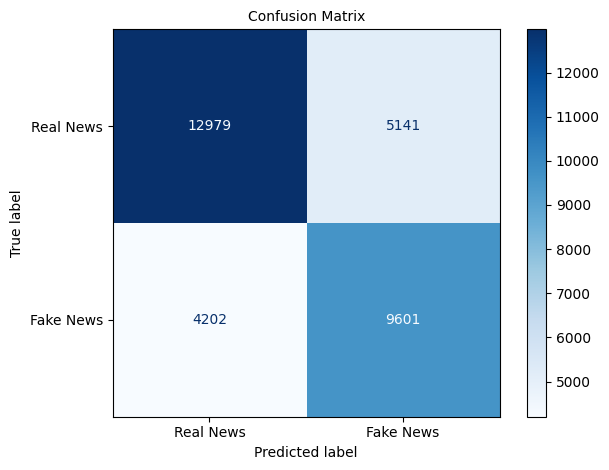

In [36]:
y_pred = model.predict(X_test_emb)

evaluate_model(y_test=y_test, y_pred=y_pred)